# Weight Quantization for SNN


In [1]:
# Libraries
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import os

In [3]:
# Path to the current directory
my_path = os.path.abspath('')
print(my_path)

c:\Users\Andres\OneDrive - Singapore University of Technology and Design\SUTD-Lab Documentation\Projects\PC-FPGA Interface\Weight_quantize


## 1) Original Java code for quantization
The quantization algorithm calculate the equivalent integer fraction to $2^4 = 16$, and only uses modular arithmetic to restric the maximum value to $2^{14} = 16384$.  
- Modular arithmetic modulo $n$ uses the mod operation to reduce the answers of all computations to a range  $[0, n−1]$.  
- Specifically, modular multiplication is expressed as: $(a * b) \mod m$.

JavaScript implement the modulo operator (%) with the remainder taking the sign of the dividend $(a * b)$, whereas Python uses the sign of the divisor $(m)$.  
- Sign of the dividend algorithm: $r = x - (n * ceil(x/n))$.
- Ceiling function maps to the least integer greater than or equal to the value.   

https://realpython.com/python-modulo-operator/#modulo-operator-with-a-negative-operand

In [5]:
# Read the weight file
# The data is already transform to number
df = pd.read_table(my_path + "\data\mnist_cnn_fix_w0.txt", sep="\t", names=['Weights'])

In [6]:
display(df)
print(df.dtypes)

,Weights
0,-0.015037
1,0.242221
2,0.514546
3,0.332993
4,-0.039131
...,...
139,0.085104
140,0.187078
141,-0.041551
142,0.640989


Weights    float64
dtype: object


In [7]:
# Turn it into a numpy array
# Verify the data type
w_array = df.to_numpy()
# print(w_array.flatten())
# print(w_array.dtype)

In [8]:
# Reproduce this part of the original code
# FixedPointNumber.toFix(conv1_weight[i])

# There are some constants defined in FixedPointNumber: Integers
fixed_point = 4
# print(type(fixed_point))

int_length = 10
# print(type(int_length))

# number represented in 5 bits (0x10)
# 5 bits -> 0 - 31
one = 1 << fixed_point
print(f'Constant ONE = {one}')
# print(type(one))

# number represented in 15 bits (0x4000)
cut = 1 << (fixed_point+int_length)
print(f'Constant CUT = {cut}')
# print(type(cut))

Constant ONE = 16
Constant CUT = 16384


In [9]:
"""
Quantization function in Java
"""

# Precedence in Java
#1. Multiplication, division and remainder operations are applied first. 
# If an expression contains several such operations, they're applied from left to right. 
# Multiplication, division and remainder operators have the same level of precedence.

# Formula --> return ((int) (val * ONE % CUT));

def FixedPointNumber(w_array):
    # Number of bits -1 to represent the weight
    fixed_point = 4
    
    # Number of bits for the integer?
    int_length = 10
    
    # Max value
    # number represented in 5 bits (0x10)
    one = 1 << fixed_point
    
    # Modulus
    # number represented in 15 bits (0x4000)
    cut = 1 << (fixed_point+int_length)
    
    # return ( w_array * one  % cut)#.astype(int)
    # return (w_array * one).astype(int)
    return(np.fmod(w_array * one, cut)).astype(int) 

In [10]:
# Test the Limits of the java quantization function
aux1 = np.array([-0.751497209072113, -1020, 1024, -1024])
print(aux1)
print(FixedPointNumber(aux1))

[-7.51497209e-01 -1.02000000e+03  1.02400000e+03 -1.02400000e+03]
[   -12 -16320      0      0]


In [11]:
"""
De- Quantization function in Java
"""
# return ((float) fix) / ONE;
def floatVal(w_array):
    # Number of bits -1 to represent the weight
    fixed_point = 4
    
    # Max value
    # number represented in 5 bits (0x10)
    one = 1 << fixed_point
    return (w_array/one).astype(float)

In [12]:
# Original values
print(f'Original weights: \n {w_array.flatten()}')

# Quantize the weight values
w_fixed = FixedPointNumber(w_array)
print(f'\n Weight using Java Quantization: \n {w_fixed.flatten()}')

# De-quantize the weight values
w_float = floatVal(w_fixed)
print(f'\n Weight using Java De-Quantization: \n {w_float.flatten()}')

Original weights: 
 [-0.01503685  0.24222127  0.51454574  0.33299267 -0.03913149  0.09505473
  0.11166988  0.0920589  -0.24330366  0.31023592  0.30613697 -0.28191042
 -0.53026193  0.60777217 -0.18882188 -0.04353855 -0.24409688  0.29980499
  0.57689768 -0.10908322 -0.03723208  0.51068974  0.2169601   0.06212263
 -0.05898033  0.61827874  0.45948687 -0.08961802 -0.15117338  0.41852593
  0.00704344  0.44114468 -0.22077379  0.15196952  0.32017583 -0.35794991
 -0.57591033  0.15012182  0.5180462   0.42396036  0.07670959  0.77622014
  0.52273047  0.1593399   0.13123228 -0.12890141 -0.20709385  0.2941924
  0.45859686  0.39585656  0.21515225 -0.01544973 -0.15934244 -0.09055397
 -0.02771167 -0.11606839  0.34786159 -0.14292923 -0.26374003  0.27508855
 -0.53912205  1.          0.04642181  0.37358621  0.63844895  0.65337342
  0.14284296  0.10353711  0.01303973  0.50580692  0.30079883  0.25400051
 -0.12091796 -0.06509083 -0.25035253 -0.19849075  0.02583558  0.58720344
  0.29721719  0.43783069  0.7069

## 2) Use quantization formulas from TensorFlow/Pytorch
https://leimao.github.io/article/Neural-Networks-Quantization/

Quantization maps a floating-point value $x \in [\alpha, \beta]$ to a $b$ -bit integer $x_q \in [\alpha_q, \beta_q]$  
- De-quantization process:  
$$x = s(x_q - z)$$
- Quantization process:  
$$x_q = round(\frac{1}{s}x + z)$$
- The values of scale $s$ and zero point $z$:
    - $z$ is an integer and $s$ is a positive floating-point number. 
$$s = \frac{\beta - \alpha}{\beta_q - \alpha_q}$$
$$z = round\left(\frac{\beta \alpha_q - \alpha \beta_q}{\beta - \alpha}\right)$$
- Value clipping fix the values in the defined range.
    - signed INTb $(\alpha_q, \beta_q) = (-2^{b-1}, 2^{b-1} - 1)$
    - unsigned UINTb $(\alpha_q, \beta_q) = (0, 2^{b} - 1)$
$$x_q = clip\left(round\left(\frac{\beta \alpha_q - \alpha \beta_q}{\beta - \alpha}\right), \alpha_q, \beta_q\right)$$
$$clip(x,l,u)=
    \begin{cases}
        l & \text{if } x < l\\
        x & \text{if } l \leq x \leq u\\
        u & \text{if } x > u
    \end{cases}$$

- To define the appropiate $[\alpha, \beta]$, we can use Min-max or Mean squared error approches.
    - https://arxiv.org/abs/2106.08295
    - https://arxiv.org/abs/1810.05723v3 

In [13]:
# Generate quantization constants
"""
(alpha, beta) --> floating-point value range
n_bit --> number of bits for quantization:
"""

def gen_qc(alpha, beta, n_bit):

    # Define the range of the quantized value (INTb)
    alpha_q = -2**(n_bit - 1)
    beta_q = 2**(n_bit - 1) - 1

    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))

    return s, z, alpha_q, beta_q

In [14]:
# Quantize a floating-point number to b-bit INT
"""
x --> floating-point value
(alpha, beta) --> floating-point values interval
n_bit --> number of bits
"""

def q_intb(x, alpha, beta, n_bit):
    
    # Generate the constants and interval for quantized values
    s, z, alpha_q, beta_q = gen_qc(alpha, beta, n_bit) 

    # Calculate the quantize value
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)

    # Specify as INT type
    x_q = x_q.astype(np.int8)

    return x_q

In [15]:
# De-quantize function
"""
x_q --> quantized value
(s,z) --> constants
"""

def dq_intb(x_q, s, z):

    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float32)

    return x

In [16]:
# Example

# Weights from the java file
x = np.array([-1.705539077520370483e-01, -1.617787480354309082e-01, 3.029945790767669678e-01, -3.226774334907531738e-01,
              8.391460031270980835e-02, -1.260133385658264160e-01, -1.162799149751663208e-01, 3.115382790565490723e-01,
              5.627775192260742188e-02, -3.229042142629623413e-02])

alpha = np.min(x)
beta = np.max(x)
print(x.dtype)
print(alpha)
print(beta)

float64
-0.3226774334907532
0.3115382790565491


In [17]:
# Quantize to 5-bit INT (signed)
n_bit = 5
print(x)
print(gen_qc(alpha, beta, n_bit))
x_q = q_intb(x, alpha, beta, n_bit)
print(x_q.dtype)
print(x_q)

[-0.17055391 -0.16177875  0.30299458 -0.32267743  0.0839146  -0.12601334
 -0.11627991  0.31153828  0.05627775 -0.03229042]
(0.02045857137249362, 0, -16, 15)
int8
[ -8  -8  15 -16   4  -6  -6  15   3  -2]


In [18]:
# De-quantize the values
s, z, _,_ = gen_qc(alpha, beta, n_bit)
x_back = dq_intb(x_q, s, z)
print(x_back.dtype)
print(x_back)

float32
[-0.16366857 -0.16366857  0.30687857 -0.32733715  0.08183429 -0.12275143
 -0.12275143  0.30687857  0.06137571 -0.04091714]


## 3) Bit representation of weights
- Generate 5-bit representation of each weight
- Use of 2's complement
    - From right to left, keep the bits until the first 1, and then inverts the rest of the bits.

In [19]:
print(x)
print(x_q)

# Empty list for the string
xq_b = []

# Represent in 5 bits (2's complement)
for xq in x_q:
    xq_b.append(np.binary_repr(xq, width=n_bit))

print(type(xq_b))
print(xq_b)

[-0.17055391 -0.16177875  0.30299458 -0.32267743  0.0839146  -0.12601334
 -0.11627991  0.31153828  0.05627775 -0.03229042]
[ -8  -8  15 -16   4  -6  -6  15   3  -2]
<class 'list'>
['11000', '11000', '01111', '10000', '00100', '11010', '11010', '01111', '00011', '11110']


## 4) Quantized Trained Weights from snnTorch

In [20]:
# Set CPU or GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Running on {device}')

Running on cpu


In [21]:
# Network Architecture
# Considering the MNIST MLP from Shenjing Paper
num_inputs = 28*28
num_hidden = 512
num_outputs = 10

# From the Shenjing Requirements (java code)

# Temporal Dynamics
num_steps = 20

# Represents the decay of the membrane potential
# No decay
beta = 1

# After spiking, the membrane potential is reduced by threshold value
# reset_mechanism = "zero"

# The firing function has been modified to >= Threshold

# No bias

In [22]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(x.size(1)):           # data.size(1) =  number of time steps
            cur1 = self.fc1(x[:,step,:])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [26]:
# Use the defined class to create a new network
snn_trained = Net().to(device)

# Load the state dictionary
snn_trained.load_state_dict(torch.load(my_path + '\data\snnMNIST_model1_3.pt'))

# Set the evaluation mode for inference
# set dropout and batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
snn_trained.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (lif1): Leaky()
  (fc2): Linear(in_features=512, out_features=10, bias=False)
  (lif2): Leaky()
)

In [27]:
# Print the load model's state_dict
print("Trained SNN Model's state_dict:\n")
for param_tensor in snn_trained.state_dict():
    print(param_tensor, "\t", snn_trained.state_dict()[param_tensor].size())

Trained SNN Model's state_dict:

fc1.weight 	 torch.Size([512, 784])
lif1.threshold 	 torch.Size([])
lif1.graded_spikes_factor 	 torch.Size([])
lif1.reset_mechanism_val 	 torch.Size([])
lif1.beta 	 torch.Size([])
fc2.weight 	 torch.Size([10, 512])
lif2.threshold 	 torch.Size([])
lif2.graded_spikes_factor 	 torch.Size([])
lif2.reset_mechanism_val 	 torch.Size([])
lif2.beta 	 torch.Size([])


#### 4.1) FC1

In [28]:
# Get the weights from the FC 1
fc1_w = snn_trained.state_dict()['fc1.weight']
print(fc1_w.shape)
print(fc1_w)

torch.Size([512, 784])
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0164, -0.0060, -0.0061,  ...,  0.0229, -0.0048,  0.0226],
        [ 0.0267, -0.0280, -0.0300,  ..., -0.0287,  0.0278,  0.0038],
        [ 0.0227, -0.0338,  0.0157,  ...,  0.0127, -0.0127, -0.0101]])


In [35]:
# save fc1_w_fp.csv

# Convert to Numpy array
fc1_np = fc1_w.numpy() 

# Convert to a dataframe
df = pd.DataFrame(fc1_np)
# display(df)

# Save to file
df.to_csv("./results/fc1_w_fp.csv", index=False, header=False)

Edges of each bin: [-0.69128203 -0.55717003 -0.42305797 -0.28894597 -0.15483394 -0.02072191
  0.11339011  0.24750213  0.38161415  0.5157262   0.6498382 ]


(array([2.80000e+01, 2.02000e+02, 1.56400e+03, 1.56280e+04, 1.35771e+05,
        2.18556e+05, 2.81250e+04, 1.41800e+03, 9.70000e+01, 1.90000e+01]),
 array([-0.69128203, -0.55717003, -0.42305797, -0.28894597, -0.15483394,
        -0.02072191,  0.11339011,  0.24750213,  0.38161415,  0.51572621,
         0.64983821]),
 <BarContainer object of 10 artists>)

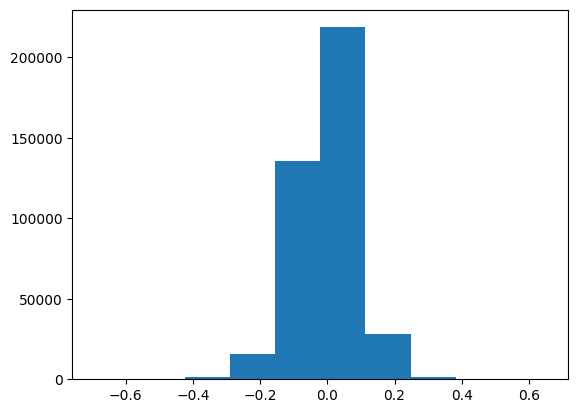

In [36]:
# Obtain the edges of each bin
bin_n = 10

hist, bin_edges = np.histogram(fc1_np.flatten(), bins=bin_n)
print(f'Edges of each bin: {bin_edges}')

# Plot histogram
plt.hist(fc1_np.flatten(), bins=bin_n)

In [37]:
# save fc1_w_q.csv

# Quantize to 5-bit INT (signed)
# Define the interval of the floating-point
n_bit = 5
# alpha = fc1_np.min()
alpha = -0.1
print(alpha)
# beta = fc1_np.max()
beta = 0.1
print(beta)

print(gen_qc(alpha, beta, n_bit))

fc1_q = q_intb(fc1_np, alpha, beta, n_bit)
# print(fc1_q.dtype)
# print(fc1_q)

# Convert to a dataframe
df = pd.DataFrame(fc1_q)
display(df)

# Save to file
df.to_csv("./results/fc1_w_q.csv", index=False, header=False)

-0.1
0.1
(0.0064516129032258064, 0, -16, 15)


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-2,0,-3,2,-5,4,-4,-4,-3,3,...,-16,-16,2,-9,-14,-1,-1,4,3,5
1,3,-5,3,-4,-4,-4,-3,-5,5,-2,...,-6,8,-7,-5,-15,-2,-2,1,0,-1
2,1,4,1,0,1,1,-2,-1,1,-4,...,-4,8,-1,0,-6,-9,4,1,4,-4
3,4,3,-4,3,1,-3,-5,1,1,-3,...,10,-4,14,-13,-16,-16,4,-2,1,-5
4,-5,-4,-4,1,5,-4,4,1,4,-3,...,15,15,14,15,15,7,-1,2,-2,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2,4,-5,3,-3,-2,3,2,-5,-4,...,-16,-13,-14,-16,-16,-8,0,0,5,5
508,-2,0,2,-3,-5,0,3,1,4,1,...,15,-11,7,-16,11,1,0,3,0,-5
509,3,-1,-1,-1,-1,0,2,5,-4,2,...,-10,-13,-3,10,13,-8,-5,4,-1,4
510,4,-4,-5,3,2,4,4,-4,-2,-1,...,15,-9,7,0,8,-9,1,-4,4,1


In [39]:
# save fc1_w_b.csv

n_bit = 5

# Create an empty dictionary to store each column
# Each key (column number) has a list of string containing the bit representation
fc1_b = {}

# Get the dimensions of weight matrix
i_w, j_w = fc1_q.shape
print(i_w)
print(j_w)

# We need to create the dictionary entries column by column
for j in range(j_w):
    
    # Empty list: quatized number in bits
    q_bit = []

    for i in range(i_w):
        # Represent in 5 bits (2's complement)
        q_bit.append(np.binary_repr(fc1_q[i][j], width=n_bit))
    
    # print(q_bit)
    # Store in the dictionary each column
    fc1_b[str(j)] = q_bit

# print(fc1_b.keys())

# Create a datadrame from the dictionary
df = pd.DataFrame(fc1_b)
display(df)

# Save to file
df.to_csv("./results/fc1_w_b.csv", index=False, header=False)


512
784


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,11110,00000,11101,00010,11011,00100,11100,11100,11101,00011,...,10000,10000,00010,10111,10010,11111,11111,00100,00011,00101
1,00011,11011,00011,11100,11100,11100,11101,11011,00101,11110,...,11010,01000,11001,11011,10001,11110,11110,00001,00000,11111
2,00001,00100,00001,00000,00001,00001,11110,11111,00001,11100,...,11100,01000,11111,00000,11010,10111,00100,00001,00100,11100
3,00100,00011,11100,00011,00001,11101,11011,00001,00001,11101,...,01010,11100,01110,10011,10000,10000,00100,11110,00001,11011
4,11011,11100,11100,00001,00101,11100,00100,00001,00100,11101,...,01111,01111,01110,01111,01111,00111,11111,00010,11110,11100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,00010,00100,11011,00011,11101,11110,00011,00010,11011,11100,...,10000,10011,10010,10000,10000,11000,00000,00000,00101,00101
508,11110,00000,00010,11101,11011,00000,00011,00001,00100,00001,...,01111,10101,00111,10000,01011,00001,00000,00011,00000,11011
509,00011,11111,11111,11111,11111,00000,00010,00101,11100,00010,...,10110,10011,11101,01010,01101,11000,11011,00100,11111,00100
510,00100,11100,11011,00011,00010,00100,00100,11100,11110,11111,...,01111,10111,00111,00000,01000,10111,00001,11100,00100,00001


In [40]:
# save fc1_w_dq.csv

# De-Quantize from 5-bit INT (signed)
# Define the interval of the floating-point
n_bit = 5
# alpha = fc1_np.min()
alpha = -0.1
print(alpha)
# beta = fc1_np.max()
beta = 0.1
print(beta)

s, z, _,_ = gen_qc(alpha, beta, n_bit)
print(f'scale = {s} and zero point = {z}')

fc1_dq = dq_intb(fc1_q, s, z)
# print(fc1_dq.dtype)
# print(fc1_dq)

# Convert to a dataframe
df = pd.DataFrame(fc1_dq)
display(df)

# Save to file
df.to_csv("./results/fc1_w_dq.csv", index=False, header=False)

-0.1
0.1
scale = 0.0064516129032258064 and zero point = 0


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.012903,0.000000,-0.019355,0.012903,-0.032258,0.025806,-0.025806,-0.025806,-0.019355,0.019355,...,-0.103226,-0.103226,0.012903,-0.058065,-0.090323,-0.006452,-0.006452,0.025806,0.019355,0.032258
1,0.019355,-0.032258,0.019355,-0.025806,-0.025806,-0.025806,-0.019355,-0.032258,0.032258,-0.012903,...,-0.038710,0.051613,-0.045161,-0.032258,-0.096774,-0.012903,-0.012903,0.006452,0.000000,-0.006452
2,0.006452,0.025806,0.006452,0.000000,0.006452,0.006452,-0.012903,-0.006452,0.006452,-0.025806,...,-0.025806,0.051613,-0.006452,0.000000,-0.038710,-0.058065,0.025806,0.006452,0.025806,-0.025806
3,0.025806,0.019355,-0.025806,0.019355,0.006452,-0.019355,-0.032258,0.006452,0.006452,-0.019355,...,0.064516,-0.025806,0.090323,-0.083871,-0.103226,-0.103226,0.025806,-0.012903,0.006452,-0.032258
4,-0.032258,-0.025806,-0.025806,0.006452,0.032258,-0.025806,0.025806,0.006452,0.025806,-0.019355,...,0.096774,0.096774,0.090323,0.096774,0.096774,0.045161,-0.006452,0.012903,-0.012903,-0.025806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.012903,0.025806,-0.032258,0.019355,-0.019355,-0.012903,0.019355,0.012903,-0.032258,-0.025806,...,-0.103226,-0.083871,-0.090323,-0.103226,-0.103226,-0.051613,0.000000,0.000000,0.032258,0.032258
508,-0.012903,0.000000,0.012903,-0.019355,-0.032258,0.000000,0.019355,0.006452,0.025806,0.006452,...,0.096774,-0.070968,0.045161,-0.103226,0.070968,0.006452,0.000000,0.019355,0.000000,-0.032258
509,0.019355,-0.006452,-0.006452,-0.006452,-0.006452,0.000000,0.012903,0.032258,-0.025806,0.012903,...,-0.064516,-0.083871,-0.019355,0.064516,0.083871,-0.051613,-0.032258,0.025806,-0.006452,0.025806
510,0.025806,-0.025806,-0.032258,0.019355,0.012903,0.025806,0.025806,-0.025806,-0.012903,-0.006452,...,0.096774,-0.058065,0.045161,0.000000,0.051613,-0.058065,0.006452,-0.025806,0.025806,0.006452


In [41]:
# save fc1_w_q_java.csv

# Quantize to 5-bit INT (signed)
# use java quantization

fc1_q_j = FixedPointNumber(fc1_np)
# print(fc1_q_j.dtype)
# print(fc1_q_j)

# Convert to a dataframe
df = pd.DataFrame(fc1_q_j)
display(df)

# Save to file
df.to_csv("./results/fc1_w_q_java.csv", index=False, header=False)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,-2,-1,0,0,-1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,-1,-1,-1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,1,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,0,0,0,0,0,...,-2,-1,-1,-2,-1,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0,0,...,1,-1,0,-2,1,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0,0,...,-1,-1,0,1,1,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
# save fc1_w_dq_java.csv

# De-Quantize from 5-bit INT (signed)
# use java de-quantization

fc1_dq_j = floatVal(fc1_q_j)
# print(fc1_q_j.dtype)
# print(fc1_q_j)

# Convert to a dataframe
df = pd.DataFrame(fc1_dq_j)
display(df)

# Save to file
df.to_csv("./results/fc1_w_dq_java.csv", index=False, header=False)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1250,-0.0625,0.0000,0.0000,-0.0625,0.0000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,-0.0625,0.0000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0625,0.0000,0.0625,-0.0625,-0.0625,-0.0625,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1250,0.0625,0.0625,0.0625,0.1250,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1250,-0.0625,-0.0625,-0.1250,-0.0625,0.0000,0.0,0.0,0.0,0.0
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0625,-0.0625,0.0000,-0.1250,0.0625,0.0000,0.0,0.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0625,-0.0625,0.0000,0.0625,0.0625,0.0000,0.0,0.0,0.0,0.0
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0


#### 4.2) FC2

In [43]:
# Get the weights and biases from the FC 2
fc2_w = snn_trained.state_dict()['fc2.weight']
print(fc2_w.shape)
print(fc2_w)

torch.Size([10, 512])
tensor([[ 0.0269, -0.0269,  0.2694,  ...,  0.0383,  0.0594, -0.1148],
        [-0.0251,  0.0942,  0.0901,  ...,  0.1966,  0.1298,  0.1439],
        [ 0.0418, -0.1724,  0.1162,  ...,  0.1120,  0.2577, -0.0169],
        ...,
        [-0.1199, -0.1885, -0.0430,  ..., -0.0743, -0.0042, -0.1982],
        [ 0.0652,  0.1772, -0.2778,  ...,  0.1464, -0.1088,  0.2313],
        [-0.4422, -0.0387,  0.1752,  ..., -0.3450, -0.1756, -0.2076]])


In [44]:
# save fc2_w_fp.csv

# Convert to Numpy array
fc2_np = fc2_w.numpy() 

# Convert to a dataframe
df = pd.DataFrame(fc2_np)
display(df)

# Save to file
df.to_csv("./results/fc2_w_fp.csv", index=False, header=False)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.026937,-0.026932,0.269351,0.299614,-0.085578,0.059106,-0.059712,0.092651,0.055782,-0.024515,...,-0.360518,0.046758,-0.161639,-0.028228,-0.341506,-0.141917,0.100170,0.038284,0.059403,-0.114819
1,-0.025107,0.094188,0.090051,0.759094,0.198463,-0.136235,0.228982,-0.125037,-0.019190,-0.198412,...,-0.029926,-0.131834,0.067112,0.067807,0.248548,0.053232,-0.079867,0.196637,0.129827,0.143943
2,0.041784,-0.172419,0.116216,-0.113485,-0.092390,0.216391,0.044634,-0.076330,0.092309,0.197056,...,0.015393,0.049663,0.249386,0.290110,-0.150553,0.101941,0.062900,0.112034,0.257742,-0.016927
3,-0.158019,-0.215113,-0.122432,-0.177020,-0.071172,0.098629,-0.098607,0.091054,0.031273,-0.042554,...,0.067927,-0.257068,-0.323767,0.060933,0.153090,0.099915,0.167930,-0.072902,-0.130205,0.208815
4,0.300024,0.088183,-0.076803,0.028222,0.051500,-0.136200,0.160080,-0.132184,-0.013648,-0.063231,...,0.051066,0.130208,-0.147429,-0.122101,-0.319667,0.073138,-0.200361,-0.031091,0.351081,0.028476
5,0.030147,0.196952,-0.283015,-0.162673,-0.177700,-0.125971,-0.384994,0.040986,-0.526495,0.064685,...,-0.280429,-0.212335,-0.211988,-0.206165,0.370875,-0.079022,0.070195,-0.231905,-0.256652,-0.694749
6,0.168110,-0.146701,-0.139269,-0.091932,-0.258206,-0.057040,-0.024646,-0.043460,-0.253927,0.037588,...,0.231131,0.021514,0.048510,-0.269437,-0.091940,0.015291,-0.177865,0.163588,-0.293618,-0.054660
7,-0.119870,-0.188522,-0.043042,-0.103111,0.022451,-0.059164,0.135476,-0.375790,-0.138820,0.143780,...,0.056935,-0.071635,0.028928,0.030306,-0.173852,-0.146624,0.192969,-0.074289,-0.004218,-0.198152
8,0.065189,0.177214,-0.277832,-0.258914,-0.021465,0.076540,0.136592,0.105935,0.198935,0.077393,...,0.081473,-0.031023,0.084256,-0.161319,-0.223413,0.121195,-0.108546,0.146425,-0.108788,0.231297
9,-0.442173,-0.038689,0.175241,-0.383753,0.087450,-0.297672,-0.395495,0.054612,0.174976,-0.293323,...,0.025349,0.165302,0.023175,-0.229797,-0.184466,-0.266906,-0.325190,-0.345035,-0.175575,-0.207606


Edges of each bin: [-1.8848177  -1.6132462  -1.3416747  -1.0701032  -0.79853165 -0.52696013
 -0.25538862  0.0161829   0.28775442  0.55932593  0.83089745]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.100e+01, 4.810e+02,
        2.449e+03, 2.046e+03, 1.050e+02, 7.000e+00]),
 array([-1.88481772, -1.6132462 , -1.34167469, -1.07010317, -0.79853165,
        -0.52696013, -0.25538862,  0.0161829 ,  0.28775442,  0.55932593,
         0.83089745]),
 <BarContainer object of 10 artists>)

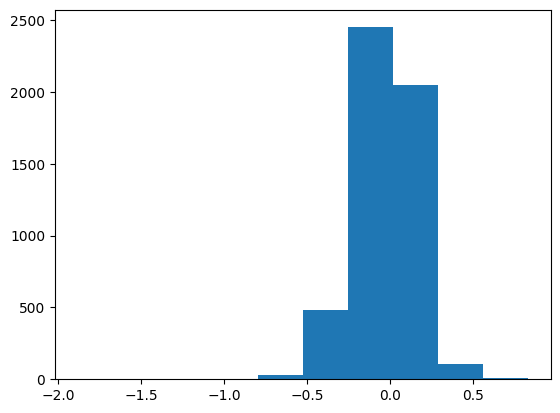

In [45]:
# Obtain the edges of each bin
bin_n = 10

hist, bin_edges = np.histogram(fc2_np.flatten(), bins=bin_n)
print(f'Edges of each bin: {bin_edges}')

# Plot histogram
plt.hist(fc2_np.flatten(), bins=bin_n)

In [46]:
# save fc2_w_q.csv

# Quantize to 5-bit INT (signed)
# Define the interval of the floating-point
n_bit = 5
# alpha = fc1_np.min()
alpha = -0.2
print(alpha)
# beta = fc1_np.max()
beta = 0.2
print(beta)

print(gen_qc(alpha, beta, n_bit))

fc2_q = q_intb(fc2_np, alpha, beta, n_bit)
# print(fc2_q.dtype)
# print(fc2_q)

# Convert to a dataframe
df = pd.DataFrame(fc2_q)
display(df)

# Save to file
df.to_csv("./results/fc2_w_q.csv", index=False, header=False)

-0.2
0.2
(0.012903225806451613, 0, -16, 15)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,2,-2,15,15,-7,5,-5,7,4,-2,...,-16,4,-13,-2,-16,-11,8,3,5,-9
1,-2,7,7,15,15,-11,15,-10,-1,-15,...,-2,-10,5,5,15,4,-6,15,10,11
2,3,-13,9,-9,-7,15,3,-6,7,15,...,1,4,15,15,-12,8,5,9,15,-1
3,-12,-16,-9,-14,-6,8,-8,7,2,-3,...,5,-16,-16,5,12,8,13,-6,-10,15
4,15,7,-6,2,4,-11,12,-10,-1,-5,...,4,10,-11,-9,-16,6,-16,-2,15,2
5,2,15,-16,-13,-14,-10,-16,3,-16,5,...,-16,-16,-16,-16,15,-6,5,-16,-16,-16
6,13,-11,-11,-7,-16,-4,-2,-3,-16,3,...,15,2,4,-16,-7,1,-14,13,-16,-4
7,-9,-15,-3,-8,2,-5,10,-16,-11,11,...,4,-6,2,2,-13,-11,15,-6,0,-15
8,5,14,-16,-16,-2,6,11,8,15,6,...,6,-2,7,-13,-16,9,-8,11,-8,15
9,-16,-3,14,-16,7,-16,-16,4,14,-16,...,2,13,2,-16,-14,-16,-16,-16,-14,-16


In [47]:
# save fc2_w_b.csv

n_bit = 5

# Create an empty dictionary to store each column
# Each key (column number) has a list of string containing the bit representation
fc2_b = {}

# Get the dimensions of weight matrix
i_w, j_w = fc2_q.shape
print(i_w)
print(j_w)

# We need to create the dictionary entries column by column
for j in range(j_w):
    
    # Empty list: quatized number in bits
    q_bit = []

    for i in range(i_w):
        # Represent in 5 bits (2's complement)
        q_bit.append(np.binary_repr(fc2_q[i][j], width=n_bit))
    
    # print(q_bit)
    # Store in the dictionary each column
    fc2_b[str(j)] = q_bit

# print(fc1_b.keys())

# Create a datadrame from the dictionary
df = pd.DataFrame(fc2_b)
display(df)

# Save to file
df.to_csv("./results/fc2_w_b.csv", index=False, header=False)

10
512


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,00010,11110,01111,01111,11001,00101,11011,00111,00100,11110,...,10000,00100,10011,11110,10000,10101,01000,00011,00101,10111
1,11110,00111,00111,01111,01111,10101,01111,10110,11111,10001,...,11110,10110,00101,00101,01111,00100,11010,01111,01010,01011
2,00011,10011,01001,10111,11001,01111,00011,11010,00111,01111,...,00001,00100,01111,01111,10100,01000,00101,01001,01111,11111
3,10100,10000,10111,10010,11010,01000,11000,00111,00010,11101,...,00101,10000,10000,00101,01100,01000,01101,11010,10110,01111
4,01111,00111,11010,00010,00100,10101,01100,10110,11111,11011,...,00100,01010,10101,10111,10000,00110,10000,11110,01111,00010
5,00010,01111,10000,10011,10010,10110,10000,00011,10000,00101,...,10000,10000,10000,10000,01111,11010,00101,10000,10000,10000
6,01101,10101,10101,11001,10000,11100,11110,11101,10000,00011,...,01111,00010,00100,10000,11001,00001,10010,01101,10000,11100
7,10111,10001,11101,11000,00010,11011,01010,10000,10101,01011,...,00100,11010,00010,00010,10011,10101,01111,11010,00000,10001
8,00101,01110,10000,10000,11110,00110,01011,01000,01111,00110,...,00110,11110,00111,10011,10000,01001,11000,01011,11000,01111
9,10000,11101,01110,10000,00111,10000,10000,00100,01110,10000,...,00010,01101,00010,10000,10010,10000,10000,10000,10010,10000


In [48]:
# save fc2_w_dq.csv

# De-Quantize from 5-bit INT (signed)
# Define the interval of the floating-point
n_bit = 5
# alpha = fc1_np.min()
alpha = -0.2
print(alpha)
# beta = fc1_np.max()
beta = 0.2
print(beta)

s, z, _,_ = gen_qc(alpha, beta, n_bit)
print(f'scale = {s} and zero point = {z}')

fc2_dq = dq_intb(fc2_q, s, z)
# print(fc1_dq.dtype)
# print(fc1_dq)

# Convert to a dataframe
df = pd.DataFrame(fc2_dq)
display(df)

# Save to file
df.to_csv("./results/fc2_w_dq.csv", index=False, header=False)

-0.2
0.2
scale = 0.012903225806451613 and zero point = 0


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.025806,-0.025806,0.193548,0.193548,-0.090323,0.064516,-0.064516,0.090323,0.051613,-0.025806,...,-0.206452,0.051613,-0.167742,-0.025806,-0.206452,-0.141935,0.103226,0.038710,0.064516,-0.116129
1,-0.025806,0.090323,0.090323,0.193548,0.193548,-0.141935,0.193548,-0.129032,-0.012903,-0.193548,...,-0.025806,-0.129032,0.064516,0.064516,0.193548,0.051613,-0.077419,0.193548,0.129032,0.141935
2,0.038710,-0.167742,0.116129,-0.116129,-0.090323,0.193548,0.038710,-0.077419,0.090323,0.193548,...,0.012903,0.051613,0.193548,0.193548,-0.154839,0.103226,0.064516,0.116129,0.193548,-0.012903
3,-0.154839,-0.206452,-0.116129,-0.180645,-0.077419,0.103226,-0.103226,0.090323,0.025806,-0.038710,...,0.064516,-0.206452,-0.206452,0.064516,0.154839,0.103226,0.167742,-0.077419,-0.129032,0.193548
4,0.193548,0.090323,-0.077419,0.025806,0.051613,-0.141935,0.154839,-0.129032,-0.012903,-0.064516,...,0.051613,0.129032,-0.141935,-0.116129,-0.206452,0.077419,-0.206452,-0.025806,0.193548,0.025806
5,0.025806,0.193548,-0.206452,-0.167742,-0.180645,-0.129032,-0.206452,0.038710,-0.206452,0.064516,...,-0.206452,-0.206452,-0.206452,-0.206452,0.193548,-0.077419,0.064516,-0.206452,-0.206452,-0.206452
6,0.167742,-0.141935,-0.141935,-0.090323,-0.206452,-0.051613,-0.025806,-0.038710,-0.206452,0.038710,...,0.193548,0.025806,0.051613,-0.206452,-0.090323,0.012903,-0.180645,0.167742,-0.206452,-0.051613
7,-0.116129,-0.193548,-0.038710,-0.103226,0.025806,-0.064516,0.129032,-0.206452,-0.141935,0.141935,...,0.051613,-0.077419,0.025806,0.025806,-0.167742,-0.141935,0.193548,-0.077419,0.000000,-0.193548
8,0.064516,0.180645,-0.206452,-0.206452,-0.025806,0.077419,0.141935,0.103226,0.193548,0.077419,...,0.077419,-0.025806,0.090323,-0.167742,-0.206452,0.116129,-0.103226,0.141935,-0.103226,0.193548
9,-0.206452,-0.038710,0.180645,-0.206452,0.090323,-0.206452,-0.206452,0.051613,0.180645,-0.206452,...,0.025806,0.167742,0.025806,-0.206452,-0.180645,-0.206452,-0.206452,-0.206452,-0.180645,-0.206452


In [49]:
# save fc2_w_q_java.csv

# Quantize to 5-bit INT (signed)
# use java quantization

fc2_q_j = FixedPointNumber(fc2_np)
# print(fc2_q_j.dtype)
# print(fc2_q_j)

# Convert to a dataframe
df = pd.DataFrame(fc2_q_j)
display(df)

# Save to file
df.to_csv("./results/fc2_w_q_java.csv", index=False, header=False)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,0,4,4,-1,0,0,1,0,0,...,-5,0,-2,0,-5,-2,1,0,0,-1
1,0,1,1,12,3,-2,3,-2,0,-3,...,0,-2,1,1,3,0,-1,3,2,2
2,0,-2,1,-1,-1,3,0,-1,1,3,...,0,0,3,4,-2,1,1,1,4,0
3,-2,-3,-1,-2,-1,1,-1,1,0,0,...,1,-4,-5,0,2,1,2,-1,-2,3
4,4,1,-1,0,0,-2,2,-2,0,-1,...,0,2,-2,-1,-5,1,-3,0,5,0
5,0,3,-4,-2,-2,-2,-6,0,-8,1,...,-4,-3,-3,-3,5,-1,1,-3,-4,-11
6,2,-2,-2,-1,-4,0,0,0,-4,0,...,3,0,0,-4,-1,0,-2,2,-4,0
7,-1,-3,0,-1,0,0,2,-6,-2,2,...,0,-1,0,0,-2,-2,3,-1,0,-3
8,1,2,-4,-4,0,1,2,1,3,1,...,1,0,1,-2,-3,1,-1,2,-1,3
9,-7,0,2,-6,1,-4,-6,0,2,-4,...,0,2,0,-3,-2,-4,-5,-5,-2,-3


In [50]:
# save fc2_w_dq_java.csv

# De-Quantize from 5-bit INT (signed)
# use java de-quantization

fc2_dq_j = floatVal(fc2_q_j)
# print(fc2_q_j.dtype)
# print(fc2_q_j)

# Convert to a dataframe
df = pd.DataFrame(fc2_dq_j)
display(df)

# Save to file
df.to_csv("./results/fc2_w_dq_java.csv", index=False, header=False)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.0000,0.0000,0.2500,0.2500,-0.0625,0.0000,0.0000,0.0625,0.0000,0.0000,...,-0.3125,0.0000,-0.1250,0.0000,-0.3125,-0.1250,0.0625,0.0000,0.0000,-0.0625
1,0.0000,0.0625,0.0625,0.7500,0.1875,-0.1250,0.1875,-0.1250,0.0000,-0.1875,...,0.0000,-0.1250,0.0625,0.0625,0.1875,0.0000,-0.0625,0.1875,0.1250,0.1250
2,0.0000,-0.1250,0.0625,-0.0625,-0.0625,0.1875,0.0000,-0.0625,0.0625,0.1875,...,0.0000,0.0000,0.1875,0.2500,-0.1250,0.0625,0.0625,0.0625,0.2500,0.0000
3,-0.1250,-0.1875,-0.0625,-0.1250,-0.0625,0.0625,-0.0625,0.0625,0.0000,0.0000,...,0.0625,-0.2500,-0.3125,0.0000,0.1250,0.0625,0.1250,-0.0625,-0.1250,0.1875
4,0.2500,0.0625,-0.0625,0.0000,0.0000,-0.1250,0.1250,-0.1250,0.0000,-0.0625,...,0.0000,0.1250,-0.1250,-0.0625,-0.3125,0.0625,-0.1875,0.0000,0.3125,0.0000
5,0.0000,0.1875,-0.2500,-0.1250,-0.1250,-0.1250,-0.3750,0.0000,-0.5000,0.0625,...,-0.2500,-0.1875,-0.1875,-0.1875,0.3125,-0.0625,0.0625,-0.1875,-0.2500,-0.6875
6,0.1250,-0.1250,-0.1250,-0.0625,-0.2500,0.0000,0.0000,0.0000,-0.2500,0.0000,...,0.1875,0.0000,0.0000,-0.2500,-0.0625,0.0000,-0.1250,0.1250,-0.2500,0.0000
7,-0.0625,-0.1875,0.0000,-0.0625,0.0000,0.0000,0.1250,-0.3750,-0.1250,0.1250,...,0.0000,-0.0625,0.0000,0.0000,-0.1250,-0.1250,0.1875,-0.0625,0.0000,-0.1875
8,0.0625,0.1250,-0.2500,-0.2500,0.0000,0.0625,0.1250,0.0625,0.1875,0.0625,...,0.0625,0.0000,0.0625,-0.1250,-0.1875,0.0625,-0.0625,0.1250,-0.0625,0.1875
9,-0.4375,0.0000,0.1250,-0.3750,0.0625,-0.2500,-0.3750,0.0000,0.1250,-0.2500,...,0.0000,0.1250,0.0000,-0.1875,-0.1250,-0.2500,-0.3125,-0.3125,-0.1250,-0.1875


## 5) Accuracy with Quantized Weights 

In [57]:
# Seed for reproducibility
torch.manual_seed(123)

# DataLoader arguments
batch_size = 128

dtype = torch.float

# Set CPU or GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Running on {device}')

Running on cpu


In [51]:
# We retrieve the information from Bindsnet results: Testing
with open(my_path + '\data\mnist_test.pkl', 'rb') as f:
    # Deserialize the file
    mnist_test = pickle.load(f)

In [52]:
print(type(mnist_test))
print(len(mnist_test))
print(type(mnist_test[0]))
# print(mnist_test[0])

<class 'list'>
10000
<class 'dict'>


In [58]:
# Use the defined class to create a quantized network
snn_q = Net().to(device)

# Load the state dictionary
# snn_trained.load_state_dict(torch.load(my_path + '\snnMNIST_model1_3.pt'))

# Set the evaluation mode for inference
# set dropout and batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
snn_q.eval()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in snn_q.state_dict():
    print(param_tensor, "\t", snn_q.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([512, 784])
lif1.threshold 	 torch.Size([])
lif1.graded_spikes_factor 	 torch.Size([])
lif1.reset_mechanism_val 	 torch.Size([])
lif1.beta 	 torch.Size([])
fc2.weight 	 torch.Size([10, 512])
lif2.threshold 	 torch.Size([])
lif2.graded_spikes_factor 	 torch.Size([])
lif2.reset_mechanism_val 	 torch.Size([])
lif2.beta 	 torch.Size([])


In [59]:
test_cases = ['original', 'Quantized Python', 'De-Quantized Python', 'Quantized Java', 'De-Quantized Java']

for case_n in test_cases:
    if case_n == 'original':
        fc1_name = 'fc1_w_fp.csv'
        fc2_name = 'fc2_w_fp.csv'
    
    elif case_n == 'Quantized Python':
        fc1_name = 'fc1_w_q.csv'
        fc2_name = 'fc2_w_q.csv'

    elif case_n == 'De-Quantized Python':
        fc1_name = 'fc1_w_dq.csv'
        fc2_name = 'fc2_w_dq.csv'
    
    elif case_n == 'Quantized Java':
        fc1_name = 'fc1_w_q_java.csv'
        fc2_name = 'fc2_w_q_java.csv'

    elif case_n == 'De-Quantized Java':
        fc1_name = 'fc1_w_dq_java.csv'
        fc2_name = 'fc2_w_dq_java.csv'


    model_test = model_update(fc1_name, fc2_name, model=snn_q)
    print(f'\nResults for {case_n} Model:')
    test_SNN(model_test, mnist_test)


Results for original Model:
Total correctly classified test set images: 9542/10000
Test Set Accuracy: 95.42% 


Results for Quantized Python Model:
Total correctly classified test set images: 2949/10000
Test Set Accuracy: 29.49% 


Results for De-Quantized Python Model:
Total correctly classified test set images: 8600/10000
Test Set Accuracy: 86.00% 


Results for Quantized Java Model:
Total correctly classified test set images: 5968/10000
Test Set Accuracy: 59.68% 


Results for De-Quantized Java Model:
Total correctly classified test set images: 8870/10000
Test Set Accuracy: 88.70% 



## 6) Testing

### 6.1) Updated weights FC1

In [135]:
# Load the quantized  weights from the .csv file
df = pd.read_csv('fc1_w_q.csv', header=None)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-2,0,-3,2,-5,4,-4,-4,-3,3,...,-16,-16,2,-9,-14,-1,-1,4,3,5
1,3,-5,3,-4,-4,-4,-3,-5,5,-2,...,-6,8,-7,-5,-15,-2,-2,1,0,-1
2,1,4,1,0,1,1,-2,-1,1,-4,...,-4,8,-1,0,-6,-9,4,1,4,-4
3,4,3,-4,3,1,-3,-5,1,1,-3,...,10,-4,14,-13,-16,-16,4,-2,1,-5
4,-5,-4,-4,1,5,-4,4,1,4,-3,...,15,15,14,15,15,7,-1,2,-2,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2,4,-5,3,-3,-2,3,2,-5,-4,...,-16,-13,-14,-16,-16,-8,0,0,5,5
508,-2,0,2,-3,-5,0,3,1,4,1,...,15,-11,7,-16,11,1,0,3,0,-5
509,3,-1,-1,-1,-1,0,2,5,-4,2,...,-10,-13,-3,10,13,-8,-5,4,-1,4
510,4,-4,-5,3,2,4,4,-4,-2,-1,...,15,-9,7,0,8,-9,1,-4,4,1


In [136]:
# Create the tensor with custom weights
fc1_w_q = torch.tensor(df.to_numpy(), dtype=torch.float32)
print(fc1_w_q)
print(fc1_w_q.shape)
print(fc1_w_q.dtype)

tensor([[-2.,  0., -3.,  ...,  4.,  3.,  5.],
        [ 3., -5.,  3.,  ...,  1.,  0., -1.],
        [ 1.,  4.,  1.,  ...,  1.,  4., -4.],
        ...,
        [ 3., -1., -1.,  ...,  4., -1.,  4.],
        [ 4., -4., -5.,  ..., -4.,  4.,  1.],
        [ 4., -5.,  2.,  ...,  2., -2., -2.]])
torch.Size([512, 784])
torch.float32


### 6.2) Updated weights FC2

In [137]:
# Load the quantized  weights from the .csv file
df = pd.read_csv('fc2_w_q.csv', header=None)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,2,-2,15,15,-7,5,-5,7,4,-2,...,-16,4,-13,-2,-16,-11,8,3,5,-9
1,-2,7,7,15,15,-11,15,-10,-1,-15,...,-2,-10,5,5,15,4,-6,15,10,11
2,3,-13,9,-9,-7,15,3,-6,7,15,...,1,4,15,15,-12,8,5,9,15,-1
3,-12,-16,-9,-14,-6,8,-8,7,2,-3,...,5,-16,-16,5,12,8,13,-6,-10,15
4,15,7,-6,2,4,-11,12,-10,-1,-5,...,4,10,-11,-9,-16,6,-16,-2,15,2
5,2,15,-16,-13,-14,-10,-16,3,-16,5,...,-16,-16,-16,-16,15,-6,5,-16,-16,-16
6,13,-11,-11,-7,-16,-4,-2,-3,-16,3,...,15,2,4,-16,-7,1,-14,13,-16,-4
7,-9,-15,-3,-8,2,-5,10,-16,-11,11,...,4,-6,2,2,-13,-11,15,-6,0,-15
8,5,14,-16,-16,-2,6,11,8,15,6,...,6,-2,7,-13,-16,9,-8,11,-8,15
9,-16,-3,14,-16,7,-16,-16,4,14,-16,...,2,13,2,-16,-14,-16,-16,-16,-14,-16


In [138]:
# Create the tensor with custom weights
fc2_w_q = torch.tensor(df.to_numpy(), dtype=torch.float32)
print(fc2_w_q)
print(fc2_w_q.shape)
print(fc2_w_q.dtype)

tensor([[  2.,  -2.,  15.,  ...,   3.,   5.,  -9.],
        [ -2.,   7.,   7.,  ...,  15.,  10.,  11.],
        [  3., -13.,   9.,  ...,   9.,  15.,  -1.],
        ...,
        [ -9., -15.,  -3.,  ...,  -6.,   0., -15.],
        [  5.,  14., -16.,  ...,  11.,  -8.,  15.],
        [-16.,  -3.,  14.,  ..., -16., -14., -16.]])
torch.Size([10, 512])
torch.float32


### 6.3) Updated Model

In [139]:
# Use the defined class to create a quantized network
snn_q = Net().to(device)

# Load the state dictionary
# snn_trained.load_state_dict(torch.load(my_path + '\snnMNIST_model1_3.pt'))

# Set the evaluation mode for inference
# set dropout and batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
snn_q.eval()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in snn_q.state_dict():
    print(param_tensor, "\t", snn_q.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([512, 784])
lif1.threshold 	 torch.Size([])
lif1.graded_spikes_factor 	 torch.Size([])
lif1.reset_mechanism_val 	 torch.Size([])
lif1.beta 	 torch.Size([])
fc2.weight 	 torch.Size([10, 512])
lif2.threshold 	 torch.Size([])
lif2.graded_spikes_factor 	 torch.Size([])
lif2.reset_mechanism_val 	 torch.Size([])
lif2.beta 	 torch.Size([])


In [140]:
print(snn_q.state_dict()['fc1.weight'])
print(snn_q.state_dict()['fc1.weight'].shape)
print(snn_q.state_dict()['fc1.weight'].dtype)

tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0164, -0.0060, -0.0061,  ...,  0.0229, -0.0048,  0.0226],
        [ 0.0267, -0.0280, -0.0300,  ..., -0.0287,  0.0278,  0.0038],
        [ 0.0227, -0.0338,  0.0157,  ...,  0.0127, -0.0127, -0.0101]])
torch.Size([512, 784])
torch.float32


In [141]:
# Copy of the state dictionary to a temporal variable
t_sd = snn_q.state_dict()

# Update the weights in the temporal variable
t_sd['fc1.weight'] = fc1_w_q
t_sd['fc2.weight'] = fc2_w_q

# Load the modified state dictionary
snn_q.load_state_dict(t_sd)
print(snn_q.state_dict()['fc1.weight'])
print(snn_q.state_dict()['fc1.weight'].shape)
print(snn_q.state_dict()['fc1.weight'].dtype)

print(snn_q.state_dict()['fc2.weight'])
print(snn_q.state_dict()['fc2.weight'].shape)
print(snn_q.state_dict()['fc2.weight'].dtype)

tensor([[-2.,  0., -3.,  ...,  4.,  3.,  5.],
        [ 3., -5.,  3.,  ...,  1.,  0., -1.],
        [ 1.,  4.,  1.,  ...,  1.,  4., -4.],
        ...,
        [ 3., -1., -1.,  ...,  4., -1.,  4.],
        [ 4., -4., -5.,  ..., -4.,  4.,  1.],
        [ 4., -5.,  2.,  ...,  2., -2., -2.]])
torch.Size([512, 784])
torch.float32
tensor([[  2.,  -2.,  15.,  ...,   3.,   5.,  -9.],
        [ -2.,   7.,   7.,  ...,  15.,  10.,  11.],
        [  3., -13.,   9.,  ...,   9.,  15.,  -1.],
        ...,
        [ -9., -15.,  -3.,  ...,  -6.,   0., -15.],
        [  5.,  14., -16.,  ...,  11.,  -8.,  15.],
        [-16.,  -3.,  14.,  ..., -16., -14., -16.]])
torch.Size([10, 512])
torch.float32


### 6.4) Calculate test accuracy

In [142]:
# Testing loop
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  snn_q.eval()
  for data_full in test_loader:
    data = data_full['encoded_image']
    data = data.float()    
 
    targets = data_full['encoded_label']
    
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = snn_q(data.view(data.size(0), 20, -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}% \n")

Total correctly classified test set images: 2949/10000
Test Set Accuracy: 29.49% 



### 6.5) Function to update model

In [54]:
def model_update(fc1_name, fc2_name, model):
    
    # Load the fc1 weights from the .csv file
    df = pd.read_csv(fc1_name, header=None)

    # Create the tensor with custom weights
    fc1_w = torch.tensor(df.to_numpy(), dtype=torch.float32)

    # Load the fc2 weights from the .csv file
    df = pd.read_csv(fc2_name, header=None)

    # Create the tensor with custom weights
    fc2_w = torch.tensor(df.to_numpy(), dtype=torch.float32)

    # Copy of the state dictionary to a temporal variable
    t_sd = model.state_dict()

    # Update the weights in the temporal variable
    t_sd['fc1.weight'] = fc1_w
    t_sd['fc2.weight'] = fc2_w

    # Load the modified state dictionary
    model.load_state_dict(t_sd)
    
    return model

### 6.6) Function to test the model

In [55]:
def test_SNN(model, mnist_test):
    # Testing loop
    total = 0
    correct = 0

    # drop_last switched to False to keep all samples
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
        model.eval()
        for data_full in test_loader:
            data = data_full['encoded_image']
            data = data.float()    
        
            targets = data_full['encoded_label']
            
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            test_spk, _ = model(data.view(data.size(0), 20, -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f"Total correctly classified test set images: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}% \n")
